In [2]:
import pandas as pd
import numpy as np
from statsbombpy import sb

In [3]:
#get match ids
match_ids = sb.matches(season_id = 106, competition_id = 43)['match_id']

/Users/Eran/opt/anaconda3/lib/python3.8/site-packages/statsbombpy/api_client.py:21: NoAuthWarning: credentials were not supplied. open data access only
  warnings.warn(


In [4]:
#set number of events
n_events = 10

In [5]:
#delete foul committed
#delete half end
#delete 1 of half start

In [6]:
#for loop get all goals
final_results = pd.DataFrame()

for selected_game in match_ids:
    df = sb.events(match_id=selected_game)
    df['timestamp'] = pd.to_datetime(df['timestamp'])
    df = df.sort_values(by=['period', 'timestamp', 'id']) # type: ignore
    df = df.reset_index(drop=True)
    goal_entries = df[df['shot_outcome'] == 'Goal']
    extracted_entries = []

    for index, goal_row in goal_entries.iterrows():
        goal_index = index
        start_index = max(0, goal_index - n_events) # type: ignore
        end_index = goal_index + 1 # type: ignore
        previous_entries = df.iloc[start_index:end_index]
        extracted_entries.extend(previous_entries.values.tolist())

    columns = df.columns
    last_events = pd.DataFrame(extracted_entries, columns=columns)
    final_results = final_results.append(last_events, ignore_index=True) # type: ignore
    

In [7]:
#turn all goals into cool dfs
num_columns = 11
num_rows = len(final_results) // num_columns
complete_df = pd.DataFrame(columns=[f'event_{i+1}' for i in range(num_columns)])

for i in range(num_rows):
    start_idx = i * num_columns
    end_idx = start_idx + num_columns
    events = final_results['type'][start_idx:end_idx].tolist()
    last_team = final_results['team'].iloc[end_idx-1]
    events = [f'{event} S' if team == last_team else f'{event} C' for event, team in zip(events, final_results['team'][start_idx:end_idx].tolist())]
    complete_df.loc[i] = events # type: ignore



In [8]:

pd.set_option('display.max_columns', None)
complete_df.iloc[10:20]


,event_1,event_2,event_3,event_4,event_5,event_6,event_7,event_8,event_9,event_10,event_11
10,Pass S,Ball Receipt* S,Carry S,Pass S,Ball Receipt* S,Carry S,Pass S,Ball Receipt* S,Block C,Ball Recovery S,Shot S
11,Foul Committed C,Foul Won S,Pass S,Ball Receipt* S,Interception C,Pressure C,Ball Recovery S,Carry S,Foul Committed C,Foul Won S,Shot S
12,Pressure C,Foul Won S,Foul Committed C,Pass S,Clearance C,Pass S,Ball Receipt* S,Shot S,Goal Keeper C,Ball Recovery S,Shot S
13,Ball Recovery S,Pass S,Ball Receipt* S,Carry S,Pressure C,Foul Committed C,Foul Won S,Pass S,Clearance C,Ball Recovery S,Shot S
14,Pressure C,Pressure C,Pass S,Ball Receipt* S,Carry S,Pass S,Carry S,Ball Receipt* S,Pressure C,Pressure C,Shot S
15,Pass S,Ball Receipt* S,Pressure C,Pass S,Carry S,Ball Receipt* S,Pressure C,Pressure C,Foul Won S,Foul Committed C,Shot S
16,Ball Recovery S,Carry S,Pass S,Carry S,Ball Receipt* S,Pass S,Carry S,Ball Receipt* S,Pass S,Ball Receipt* S,Shot S
17,Pressure C,Pass S,Clearance C,Foul Won S,Foul Committed C,Bad Behaviour C,Pass S,Ball Receipt* S,Carry S,Pressure C,Shot S
18,Pass S,Ball Receipt* S,Carry S,Pass S,Half End S,Half End C,Half Start C,Half Start S,Shot C,Goal Keeper S,Shot S
19,Half End S,Half End C,Half Start C,Half Start S,Shot C,Goal Keeper S,Shot S,Goal Keeper C,Shot C,Goal Keeper S,Shot S


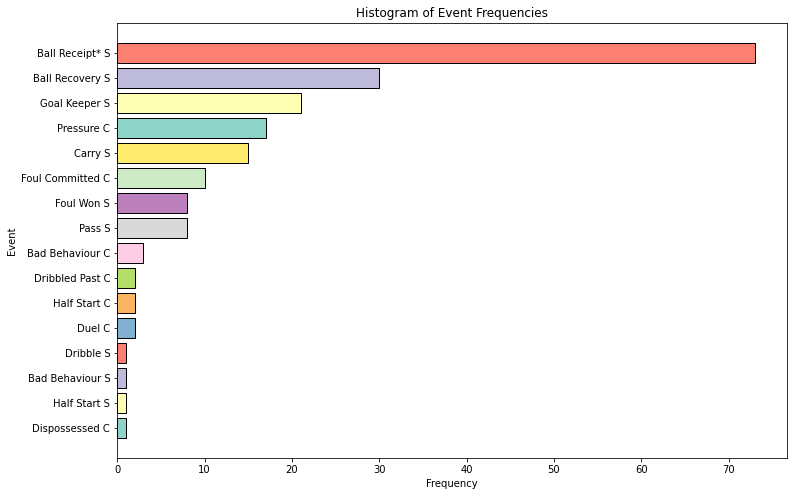

In [10]:
#wowz
import matplotlib.pyplot as plt
from palettable import colorbrewer

num_bins = len(complete_df['event_10'].unique())
event_counts = complete_df['event_10'].value_counts().sort_values(ascending=True)
events = event_counts.index.tolist()
frequencies = event_counts.tolist()

colors = colorbrewer.qualitative.Set3_12.mpl_colors # type: ignore
plt.barh(events, frequencies, color=colors, edgecolor='black')
plt.xlabel('Frequency')
plt.ylabel('Event')
plt.title('Histogram of Event Frequencies')
plt.rcParams['figure.figsize'] = [12, 8]
plt.show()